In [3]:
%pip install scanpy matplotlib-venn harmonypy liedenalg

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#liedenalg': Expected package name at the start of dependency specifier
    #liedenalg
    ^


In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt

In [29]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Iterative QC

## Loading of the datasets

In [3]:
path_filtered_files_h5 = '/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Data/h5_files_filtered'

In [4]:
adatas = [x for x in os.listdir(path_filtered_files_h5 ) 
          if x.endswith('.h5')]

In [5]:
def load_it(adata):
    samp= adata.split('_')[5]
    dpi_end = adata.split('_')[6]
    dpi = dpi_end.split('.')[0]
    adata = sc.read_10x_h5(path_filtered_files_h5 + '/' + adata)
    adata.obs['Sample'] = samp
    adata.obs['dpi'] = dpi
    adata.obs['Id'] = adata.obs['Sample'] + '_' + adata.obs['dpi']
    adata.obs.index = adata.obs.index + '-' + samp + '_' + dpi

    return adata

In [6]:
adatas = [load_it(ad) for ad in adatas]

In [7]:
adatas

[AnnData object with n_obs × n_vars = 9137 × 18087
     obs: 'Sample', 'dpi', 'Id'
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 10542 × 18087
     obs: 'Sample', 'dpi', 'Id'
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 8525 × 18087
     obs: 'Sample', 'dpi', 'Id'
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 11004 × 18087
     obs: 'Sample', 'dpi', 'Id'
     var: 'gene_ids', 'feature_types', 'genome']

## QC evaluation

In [8]:
for ad in adatas:
    ad.var_names_make_unique()

In [9]:
def qc(adata):
    sc.pp.filter_cells(adata, min_genes = 200)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith("RPS", "RPL")
    adata.var["hb"] = adata.var_names.str.startswith("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(adata,qc_vars=["mt","ribo","hb"], inplace = True, percent_top = [20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo',
              'log1p_total_counts_ribo','total_counts_hb','log1p_total_counts_hb']

    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    return adata

In [10]:
adatas = [qc(ad) for ad in adatas]

In [14]:
adatas[0].obs

,Sample,dpi,Id,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
AAACAAGCAGCTCGCTATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4730,4730,8.461892,14274.0,9.566265,18.775396,0.175144,0.0,0.0
AAACCAATCACCTAATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,8415,8415,9.037890,54307.0,10.902427,19.159593,0.252270,0.0,0.0
AAACCAATCATTATGCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5073,5073,8.531885,18919.0,9.847975,29.494159,0.190285,0.0,0.0
AAACCAATCATTGCATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5705,5705,8.649274,20530.0,9.929691,16.585485,0.998539,0.0,0.0
AAACCAATCCAAATTCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5398,5398,8.593969,14307.0,9.568574,6.304606,0.146781,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGGTAACTACCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,2631,2631,7.875499,4842.0,8.485290,15.386204,0.309789,0.0,0.0
TTTGGCGGTAAGCGTAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4769,4769,8.470102,15426.0,9.643874,15.493323,0.187994,0.0,0.0
TTTGGCGGTCTGTGATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,3147,3147,8.054523,7126.0,8.871646,22.537188,0.266629,0.0,0.0
TTTGGCGGTTGGATGAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4975,4975,8.512382,15833.0,9.669915,15.208741,0.025264,0.0,0.0


In [3]:
os.makedirs('/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data', exist_ok = True)

In [16]:
for ad in adatas:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data/adata_Inf_J6.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data/adata_Mock_J3.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data/adata_Mock_J6.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/qc_data/adata_Inf_J3.h5ad


## Doublet software to find them

In [ ]:
#scDbFinder in Rstudio

In [ ]:
#Use the file QC R in the folder R files

In [4]:
path_scDbFinder_data = "/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output/scDbFinder_dataR"

In [5]:
adatas = [sc.read_h5ad(path_scDbFinder_data + '/' + x) for x in os.listdir(path_scDbFinder_data)]

In [6]:
adatas

[AnnData object with n_obs × n_vars = 9128 × 18087
     obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 8525 × 18087
     obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p

In [7]:
adatas[0].obs

,Sample,dpi,Id,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet_score_scDbFinder,doublet_class_scDbFinder
AAACAAGCAGCTCGCTATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4730.0,4730,8.461892,14274.0,9.566265,18.775396,0.175144,0.0,0.0,0.029705,singlet
AAACCAATCACCTAATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,8415.0,8415,9.037890,54307.0,10.902427,19.159593,0.252270,0.0,0.0,0.999955,doublet
AAACCAATCATTATGCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5073.0,5073,8.531885,18919.0,9.847975,29.494159,0.190285,0.0,0.0,0.002290,singlet
AAACCAATCATTGCATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5705.0,5705,8.649274,20530.0,9.929691,16.585485,0.998539,0.0,0.0,0.994010,doublet
AAACCAATCCAAATTCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5398.0,5398,8.593969,14307.0,9.568574,6.304606,0.146781,0.0,0.0,0.015603,singlet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGGTAACTACCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,2631.0,2631,7.875499,4842.0,8.485290,15.386204,0.309789,0.0,0.0,0.000367,singlet
TTTGGCGGTAAGCGTAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4769.0,4769,8.470102,15426.0,9.643874,15.493323,0.187994,0.0,0.0,0.004287,singlet
TTTGGCGGTCTGTGATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,3147.0,3147,8.054523,7126.0,8.871646,22.537188,0.266629,0.0,0.0,0.012853,singlet
TTTGGCGGTTGGATGAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4975.0,4975,8.512382,15833.0,9.669915,15.208741,0.025264,0.0,0.0,0.002952,singlet


## Outliers annotation

In [8]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

In [9]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

In [25]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 6] 
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata.obs['Outlier'] = bool_vector

    adata.uns['cells_removed'] = sum(bool_vector)

    doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet_dbd"] = doublets
    adata.obs["doublet_score_dbd"] = doublet_score

    adata.uns['doublets_removed_dbd'] = adata.obs.doublet_dbd.sum()
    #adata = adata[adata.obs.doublet_dbd == 0]
    #adata = adata[adata.obs.doublet_class_scDbFinder == 0]

    return adata

In [26]:
adatas = [pp(ad) for ad in adatas]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed_dbd'],adata.obs.doublet_class_scDbFinder.value_counts())

7287 808 938.0 doublet_class_scDbFinder
singlet    6007
doublet    1280
Name: count, dtype: int64
6805 766 859.0 doublet_class_scDbFinder
singlet    5398
doublet    1407
Name: count, dtype: int64
8699 1059 1039.0 doublet_class_scDbFinder
singlet    7142
doublet    1557
Name: count, dtype: int64
8057 1085 1108.0 doublet_class_scDbFinder
singlet    6753
doublet    1304
Name: count, dtype: int64


In [28]:
adatas[0][adatas[0].obs.doublet_class_scDbFinder == 'singlet'].obs

,Sample,dpi,Id,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet_score_scDbFinder,doublet_class_scDbFinder,doublet_dbd,doublet_score_dbd,Outlier
AAACAAGCAGCTCGCTATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4730.0,4730,8.461892,14274.0,9.566265,18.775396,0.175144,0.0,0.0,0.029705,singlet,0.0,2.394973e-12,False
AAACCAATCATTATGCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5073.0,5073,8.531885,18919.0,9.847975,29.494159,0.190285,0.0,0.0,0.002290,singlet,0.0,4.073231e-09,False
AAACCAATCCAAATTCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5398.0,5398,8.593969,14307.0,9.568574,6.304606,0.146781,0.0,0.0,0.015603,singlet,0.0,4.614165e-12,False
AAACCAATCGAAATGCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,5514.0,5514,8.615227,20776.0,9.941602,24.234694,0.096265,0.0,0.0,0.026639,singlet,0.0,1.100250e-07,False
AAACCAATCTGGAACGATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4395.0,4395,8.388450,11835.0,9.378901,17.769328,0.430925,0.0,0.0,0.108566,singlet,0.0,1.459603e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGGTAACTACCATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,2631.0,2631,7.875499,4842.0,8.485290,15.386204,0.309789,0.0,0.0,0.000367,singlet,0.0,3.244781e-20,False
TTTGGCGGTAAGCGTAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4769.0,4769,8.470102,15426.0,9.643874,15.493323,0.187994,0.0,0.0,0.004287,singlet,0.0,1.685704e-11,False
TTTGGCGGTCTGTGATATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,3147.0,3147,8.054523,7126.0,8.871646,22.537188,0.266629,0.0,0.0,0.012853,singlet,0.0,3.574045e-11,False
TTTGGCGGTTGGATGAATGTTGAC-1-Inf_J6,Inf,J6,Inf_J6,4975.0,4975,8.512382,15833.0,9.669915,15.208741,0.025264,0.0,0.0,0.002952,singlet,0.0,7.915503e-14,False


In [29]:
#def filter_doublets(adata):           -->    removed to keep the outliers 
    #adata = adata[adata.obs.doublet_class_scDbFinder == 'singlet']
    #return adata

In [30]:
#adatas = [filter_doublets(ad) for ad in adatas]

In [31]:
adatas

[AnnData object with n_obs × n_vars = 7287 × 18087
     obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder', 'doublet_dbd', 'doublet_score_dbd', 'Outlier'
     var: 'gene_names', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed', 'doublets_removed_dbd',
 AnnData object with n_obs × n_vars = 6805 × 18087
     obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder', 'doublet_dbd', 'doublet_score_dbd', 'Outlier'
     var: 'gene_names', 'fe

In [32]:
os.makedirs('/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data', exist_ok = True)

In [33]:
for ad in adatas:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data/adata_Inf_J6.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data/adata_Mock_J6.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data/adata_Inf_J3.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scRNA/Output_iteration/processed_data/adata_Mock_J3.h5ad


In [5]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt
import scanpy.external as sce

## Integration

In [13]:
path_data_eval = 'G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/processed_data'

In [14]:
adatas = [sc.read_h5ad(path_data_eval + '/' + x) for x in os.listdir(path_data_eval)]

In [19]:
adatas[0].obs

,Sample,dpi,Id,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb,doublet_score_scDbFinder,doublet_class_scDbFinder,doublet_dbd,doublet_score_dbd,Outlier
AAACAAGCAAGAACAAAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,4997.0,4997,8.516793,15760.0,9.665294,16.935279,0.158629,0.0,0.0,0.001438,singlet,0.0,5.291358e-09,False
AAACAAGCACAATGGCAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,7298.0,7298,8.895493,36604.0,10.507940,22.724292,0.519069,0.0,0.0,0.999841,doublet,1.0,1.677088e+02,True
AAACAAGCACACTAAGAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,4357.0,4357,8.379769,14550.0,9.585415,26.054983,0.041237,0.0,0.0,0.004471,singlet,0.0,1.448281e-12,False
AAACAAGCACCGTTTGAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,6425.0,6425,8.768108,37675.0,10.536778,39.777040,0.172528,0.0,0.0,0.175868,singlet,0.0,3.125093e+01,False
AAACAAGCACTTCGATAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,4802.0,4802,8.476996,12024.0,9.394743,9.971723,0.024950,0.0,0.0,0.001208,singlet,0.0,3.758603e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAGTCCTTATTAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,4338.0,4338,8.375399,12116.0,9.402365,21.153846,0.198085,0.0,0.0,0.003729,singlet,0.0,7.035109e-20,False
TTTGTGAGTCGAAGTAAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,7765.0,7765,8.957511,43462.0,10.679666,13.416318,0.147255,0.0,0.0,0.999568,doublet,1.0,1.398291e+02,False
TTTGTGAGTGCTGATTAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,5193.0,5193,8.555259,16969.0,9.739202,16.052802,0.070717,0.0,0.0,0.000273,singlet,0.0,4.303000e-05,False
TTTGTGAGTGTCCAATAGTAGGCT-1-Inf_J3,Inf,J3,Inf_J3,5683.0,5683,8.645410,17963.0,9.796125,20.503257,0.011134,0.0,0.0,0.038671,singlet,1.0,1.175947e+02,False


In [10]:
def reindexing(adata):
    
    adata.var = adata.var.reset_index()
    adata.var = adata.var.rename(columns={'index': 'gene_names'})
    adata.var = adata.var.set_index('gene_ids')
    adata.var = adata.var.rename_axis(None)

    return adata

In [11]:
adatas = [reindexing(ad) for ad in adatas]

KeyError: "None of ['gene_ids'] are in the columns"

In [16]:
adatas[2].var

,gene_names,feature_types,genome,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000187634,SAMD11,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,5,0.000474,0.000474,99.952571,5.0,1.791759
ENSG00000188976,NOC2L,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,4223,0.592961,0.465595,59.941188,6251.0,8.740657
ENSG00000187961,KLHL17,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,719,0.072946,0.070408,93.179662,769.0,6.646390
ENSG00000187583,PLEKHN1,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,1400,0.190571,0.174433,86.719788,2009.0,7.605890
ENSG00000187642,PERM1,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,73,0.007873,0.007842,99.307532,83.0,4.430817
...,...,...,...,...,...,...,...,...,...,...,...,...
EGFP,EGFP,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,8,0.000759,0.000759,99.924113,8.0,2.197225
REPLI,REPLI,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,1,0.000095,0.000095,99.990514,1.0,0.693147
GLYCO,GLYCO,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,6,0.000569,0.000569,99.943085,6.0,1.945910
MEMB,MEMB,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False,14,0.001423,0.001422,99.867198,15.0,2.772589


In [20]:
adata = adt.concat(adatas, join="outer", index_unique="-", merge="unique")

In [21]:
adata.var

,gene_names,feature_types,genome,mt,ribo,hb
ENSG00000187634,SAMD11,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
ENSG00000188976,NOC2L,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
ENSG00000187961,KLHL17,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
ENSG00000187583,PLEKHN1,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
ENSG00000187642,PERM1,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
...,...,...,...,...,...,...
EGFP,EGFP,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
REPLI,REPLI,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
GLYCO,GLYCO,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False
MEMB,MEMB,Gene Expression,refdata-gex-GRCh38-2020-A_customprobe1,False,False,False


In [22]:
os.makedirs('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_concat', exist_ok = True)

In [23]:
file_path = os.path.join('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_concat', f'adata_concat.h5ad')
adata.write(file_path)

# Test to see the impact of scVI and integration over the shape of the UMAP

In [38]:
adata = sc.read_h5ad('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_concat/adata_concat.h5ad')

In [39]:
adata.layers["raw_counts"] = adata.X.copy() # create back up save of the raw data. Use adata.raw

In [40]:
adata

AnnData object with n_obs × n_vars = 30848 × 18087
    obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder', 'doublet_dbd', 'doublet_score_dbd', 'Outlier'
    var: 'gene_names', 'feature_types', 'genome', 'mt', 'ribo', 'hb'
    layers: 'raw_counts'

In [41]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [42]:
adata.X = adata.layers["log1p_norm"]

In [43]:
adata

AnnData object with n_obs × n_vars = 30848 × 18087
    obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder', 'doublet_dbd', 'doublet_score_dbd', 'Outlier'
    var: 'gene_names', 'feature_types', 'genome', 'mt', 'ribo', 'hb'
    layers: 'raw_counts', 'log1p_norm'

In [44]:
sc.pp.highly_variable_genes(adata, subset=False) 
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=True)

In [45]:
adata

AnnData object with n_obs × n_vars = 30848 × 18087
    obs: 'Sample', 'dpi', 'Id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score_scDbFinder', 'doublet_class_scDbFinder', 'doublet_dbd', 'doublet_score_dbd', 'Outlier'
    var: 'gene_names', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'log1p_norm'

In [48]:
adata.obsm['X_pca']

array([[-5.074962  ,  1.4320024 ,  4.1630816 , ..., -0.32412383,
        -0.5490262 ,  2.4435685 ],
       [-4.5785103 , -2.6777923 ,  2.7937915 , ...,  0.03268271,
         0.11615332, -0.5947018 ],
       [-6.206676  , -2.7483468 , -2.426077  , ..., -0.15226312,
         0.07282516, -1.1557364 ],
       ...,
       [-6.428854  , -3.1338463 , -1.3208046 , ..., -0.9302328 ,
        -0.05215501, -1.8780318 ],
       [-5.8764095 , -2.9817307 , -2.0615318 , ..., -1.8670813 ,
         1.6455821 , -2.6259954 ],
       [-4.4112515 ,  4.316961  ,  3.4132094 , ...,  1.241751  ,
         0.11570999,  1.3333904 ]], dtype=float32)

In [49]:
sc.pp.neighbors(adata, use_rep = 'X_pca')

In [50]:
sc.tl.leiden(adata, resolution = 3, key_added = 'overcluster')

In [51]:
sc.tl.umap(adata)

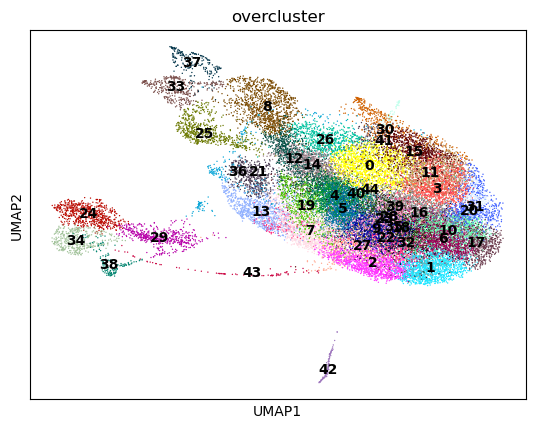

In [52]:
sc.pl.umap(
    adata,
    color=['overcluster'],
    legend_loc="on data",
)

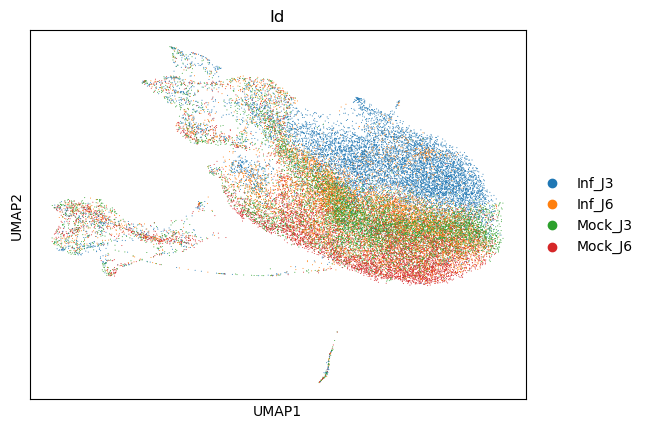

In [53]:
np.random.seed(1)
ri = np.random.permutation(list(range(adata.shape[0])))

sc.pl.umap(adata[ri,:], color = ['Id'], vmin = .5, size = 2)

In [54]:
genes_of_interest = ['EGFP', 'GLYCO', 'MEMB', 'NUCL', 'REPLI']

In [55]:
adata.obs['229E'] = adata[:, genes_of_interest].X.sum(axis=1) > 0

<Axes: title={'center': '229E'}, xlabel='UMAP1', ylabel='UMAP2'>

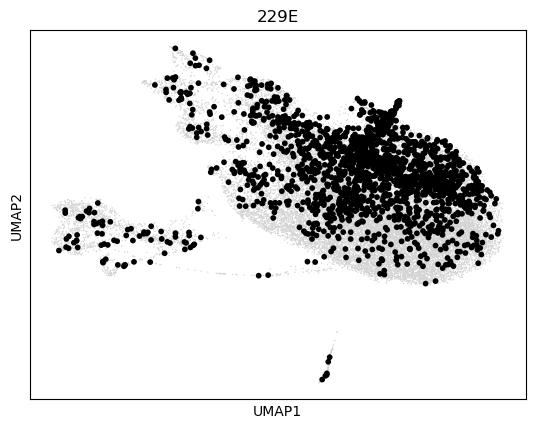

In [56]:
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)

sc.pl.umap(
    adata[adata.obs['229E'] & (adata.obs["Sample"] == "Inf")], 
    color='229E',
    ax=ax,
    legend_loc=None, 
    palette=['k'],
    show=False)

<Axes: title={'center': '229E'}, xlabel='UMAP1', ylabel='UMAP2'>

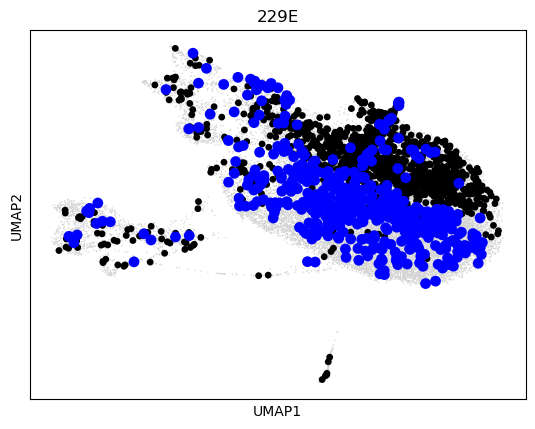

In [57]:
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)

sc.pl.umap(
    adata[adata.obs['229E'] & (adata.obs["Id"] == "Inf_J3")], 
    color='229E',
    ax=ax,
    legend_loc=None, 
    palette=['k'],
    show=False)
sc.pl.umap(
    adata[adata.obs['229E'] & (adata.obs["Id"] == "Inf_J6")], 
    color='229E',
    ax=ax,
    legend_loc=None, 
    palette=['b'],
    show=False)

In [33]:
os.makedirs('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_preharmony', exist_ok = True)

In [34]:
file_path = os.path.join('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_preharmony', f'adata_concat.h5ad')
adata.write(file_path)

In [32]:
# Harmony using R

### Transfering the harmony matrix

In [ ]:
adata_harmony = sc.read_h5ad('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_preharmony/adata_postharmony.h5ad')

In [ ]:
adata_harmony

In [ ]:
adata = sc.read_h5ad('G:/Data processing pipeline 0.1 Yohan/scRNA/Output_iteration/adata_preharmony/adata_preharmony.h5ad')

In [ ]:
adata

In [ ]:
adata.obsm['X_harmony'] = adata_harmony.obsm['X_harmony']

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony")

sc.tl.umap(adata)

In [ ]:
adata.obs['Doublet'] = (adata.obs.doublet_dbd == 1) | (adata.obs.doublet_class_scDbFinder == 'doublet')

In [ ]:
sc.pl.umap(adata, color = 'Outlier')


In [ ]:
sc.pl.umap(adata, color = 'Doublet')

In [ ]:
sc.pl.umap(adata, color = ['n_genes', 'log1p_total_counts'])

In [ ]:
# no effect of the outliers and the doublets have been seen on R and i decided to stop this process.